In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
df= pd.read_csv("../data/processed/filtered_stock_with_indicators.csv")

df.head()

,date,high,low,close,total_transaction,price_change,daily_change,daily_return,year,month,day-of-week,is-weekend,SMA-10,SMA-50,EMA_10,EMA_50,RSI_14,close_prev_day
0,2010-04-15,2040.0,2000.0,2000.0,6935470.0,NaN,40.0,NaN,2010,4,3,0,NaN,NaN,2000.000000,2000.000000,NaN,NaN
1,2010-04-19,2039.0,2000.0,2001.0,3549542.0,1.0,39.0,0.05,2010,4,0,0,NaN,NaN,2000.181818,2000.039216,100.000000,2000.0
2,2010-04-20,1975.0,1945.0,1945.0,2369304.0,-56.0,30.0,-2.80,2010,4,1,0,NaN,NaN,1990.148760,1997.880815,-1.571947,2001.0
3,2010-04-21,1908.0,1800.0,1810.0,3531917.0,-135.0,108.0,-6.94,2010,4,2,0,NaN,NaN,1957.394440,1990.512940,-0.410932,1945.0
4,2010-04-22,1831.0,1775.0,1831.0,2156607.0,21.0,56.0,1.16,2010,4,3,0,NaN,NaN,1934.413633,1984.257531,-15.756324,1810.0


In [5]:
# df.isna().sum()
df.fillna(method='ffill', inplace=True)
df.isna().sum()


/var/folders/_0/nzc90x3n5rq0qtcpn10r9hkm0000gn/T/ipykernel_37830/3663129868.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


date                  0
high                  0
low                   0
close                 0
total_transaction     0
price_change          1
daily_change          0
daily_return          1
year                  0
month                 0
day-of-week           0
is-weekend            0
SMA-10                9
SMA-50               49
EMA_10                0
EMA_50                0
RSI_14                1
close_prev_day        1
dtype: int64

In [6]:
df.fillna(method='bfill', inplace=True)
df.isna().sum()

/var/folders/_0/nzc90x3n5rq0qtcpn10r9hkm0000gn/T/ipykernel_37830/153329367.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


date                 0
high                 0
low                  0
close                0
total_transaction    0
price_change         0
daily_change         0
daily_return         0
year                 0
month                0
day-of-week          0
is-weekend           0
SMA-10               0
SMA-50               0
EMA_10               0
EMA_50               0
RSI_14               0
close_prev_day       0
dtype: int64

In [7]:
# Creating cyclical date features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day-of-week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day-of-week'] / 7)

In [8]:
feature_cols = ['SMA-10', 'SMA-50', 'EMA_10', 'EMA_50', 'RSI_14', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
X = df[feature_cols].values
y = df['close'].values

# y= df['close'].values.ravel()

In [9]:
# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
time_steps = 10  # Use past 10 days to predict the next day
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

In [12]:
# Splitting into training & test sets (time-based split)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [13]:
print(X_train.shape)
print(X_test.shape)

(2649, 10, 9)
(663, 10, 9)


In [14]:
import os
print(os.environ.get('VIRTUAL_ENV'))

/Users/aayushmoktan/Documents/Projects/Data Analysis/Nabil/new_venv_nabil


Using Multi-level-percepton (Deep Learning)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [16]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predicting closing price
])


/Users/aayushmoktan/Documents/Projects/Data Analysis/Nabil/new_venv_nabil/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:

model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2372766.2500 - val_loss: 422467.0312
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2256522.0000 - val_loss: 306995.8125
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1900899.8750 - val_loss: 171432.7656
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1536407.0000 - val_loss: 65072.5312
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1116555.7500 - val_loss: 34677.0117
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 737286.1875 - val_loss: 106819.6328
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 502784.1562 - val_loss: 248826.4062
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 361863.4375 - val_loss: 403248.7500
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 319144.8125 - val_loss: 521285.5000
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 296482.7188 - val_loss: 590297.7500
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━

In [19]:
y_pred = model.predict(X_test)

# Forecasting future prices
future_days = 10  # Predict next 10 days
future_inputs = X_test[-1:]  # Last known sequence

future_preds = []
for _ in range(future_days):
    pred = model.predict(future_inputs)
    future_preds.append(pred[0][0])  # Save predicted value
    future_inputs = np.roll(future_inputs, -1, axis=1)  # Shift input sequence
    future_inputs[0, -1, 0] = pred[0][0]  # Append new predicted value

print(future_preds)  # List of predicted future closing prices

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[np.float32(575.17804), np.float32(2207.4238), np.float32(2501.1973), np.float32(2582.0771), np.float32(2605.989), np.float32(2614.1255), np.float32(2617.2695), np.float32(2618.596), np.float32(2619.2588), np.float32(2619.577)]


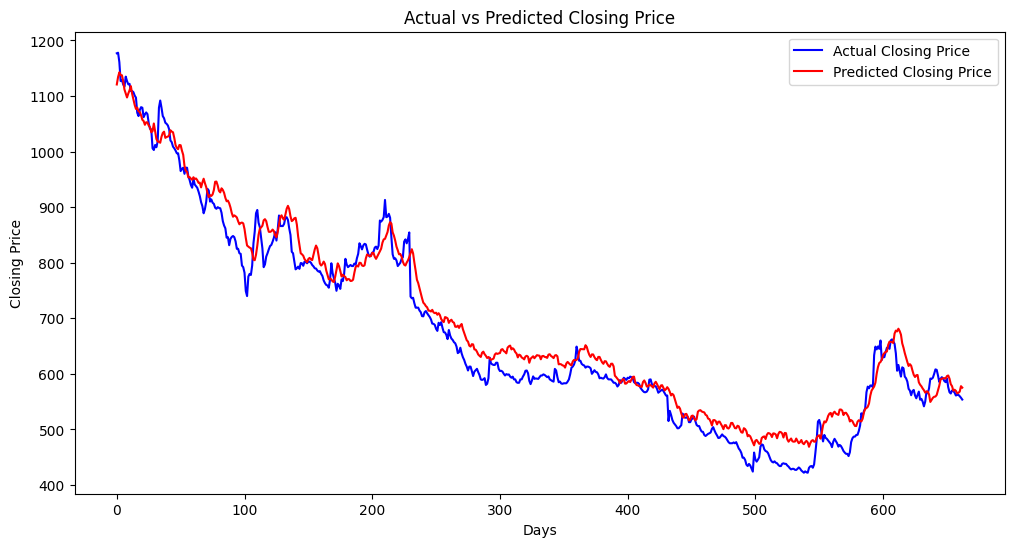

In [20]:

plt.figure(figsize=(12,6))
plt.plot(y_test, color='blue', label='Actual Closing Price')  # Actual values
plt.plot(y_pred, color='red', label='Predicted Closing Price')  # Predicted values
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 29.50419755248103
